<a href="https://colab.research.google.com/github/QhawekaziP/Content-Generator/blob/main/AIFairness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 📦 Step 1: Install Required Libraries
!pip install seaborn scikit-learn matplotlib aif360 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 6.6 MB/s eta 0:00:00


In [2]:
# 📚 Step 2: Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [3]:
# 📁 Step 3: Load and Preview the COMPAS Dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df = pd.read_csv(url)

# Select relevant columns
df = df[['age', 'race', 'sex', 'priors_count', 'two_year_recid']]
df = df[df['race'].isin(['African-American', 'Caucasian'])]  # Focus on two groups
df = df.dropna()
df.head()

,age,race,sex,priors_count,two_year_recid
1,34,African-American,Male,0,1
2,24,African-American,Male,4,1
3,23,African-American,Male,1,0
6,41,Caucasian,Male,14,1
8,39,Caucasian,Female,0,0


In [6]:
# 🎯 Step 4: Prepare Features and Labels
X = df[['age', 'priors_count']]
y = df['two_year_recid']
race = df['race']  # Save for fairness audit

# Split data
X_train, X_test, y_train, y_test, race_train, race_test = train_test_split(
    X, y, race, test_size=0.3, random_state=42
)

In [11]:
# 🤖 Step 5: Train Baseline Model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Accuracy
print("Baseline Accuracy:", accuracy_score(y_test, y_pred))

Baseline Accuracy: 0.6791327913279133


In [16]:
# ✨ Step 6: Fairness Audit - Before Mitigation
df_before = X_test.copy()
df_before['prediction'] = y_pred

# Encode 'race' to numerical values for AIF360
# 0.0 for African-American (unprivileged), 1.0 for Caucasian (privileged)
df_before['race'] = race_test.apply(lambda x: 1.0 if x == 'Caucasian' else 0.0).values

# Convert to AIF360 format
dataset_before = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=df_before,
    label_names=['prediction'],
    protected_attribute_names=['race'],
    privileged_protected_attributes=[[1.0]],  # Corrected: Use list of lists of values
    unprivileged_protected_attributes=[[0.0]] # Corrected: Use list of lists of values
)

# Compute fairness metrics
metric_before = BinaryLabelDatasetMetric(
    dataset_before,
    privileged_groups=[{'race': 1.0}],
    unprivileged_groups=[{'race': 0.0}]
)

di_before = metric_before.disparate_impact()
spd_before = metric_before.statistical_parity_difference()

print("Disparate Impact (Before):", di_before)
print("Statistical Parity Difference (Before):", spd_before)

Disparate Impact (Before): 0.675698696993416
Statistical Parity Difference (Before): -0.2589998161426732


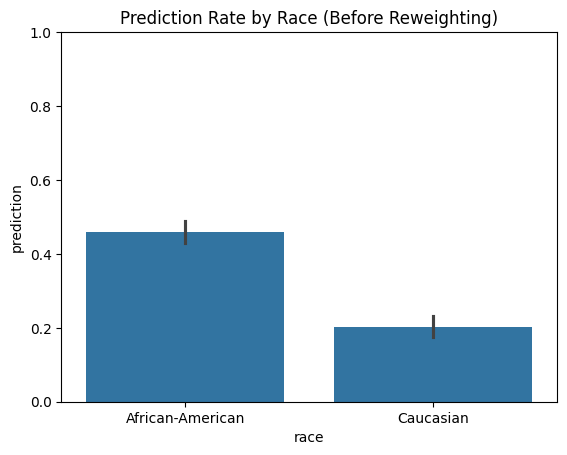

In [13]:
# 📊 Step 7: Visualize Prediction Rate by Race (Before)
sns.barplot(data=df_before, x='race', y='prediction')
plt.title('Prediction Rate by Race (Before Reweighting)')
plt.ylim(0, 1)
plt.show()

In [19]:
# 🛠️ Step 8: Bias Mitigation via Sample Reweighting
weights = race_train.apply(lambda x: 2.0 if x == 'African-American' else 1.0)

model_rw = LogisticRegression()
model_rw.fit(X_train, y_train, sample_weight=weights)
y_pred_rw = model_rw.predict(X_test)

print("Post-Mitigation Accuracy:", accuracy_score(y_test, y_pred_rw))

Post-Mitigation Accuracy: 0.6764227642276422


In [20]:
# ✨ Step 9: Fairness Audit - After Mitigation
df_after = X_test.copy()
df_after['prediction'] = y_pred_rw

# Encode 'race' to numerical values for AIF360
# 0.0 for African-American (unprivileged), 1.0 for Caucasian (privileged)
df_after['race'] = race_test.apply(lambda x: 1.0 if x == 'Caucasian' else 0.0).values

dataset_after = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=df_after,
    label_names=['prediction'],
    protected_attribute_names=['race'],
    privileged_protected_attributes=[[1.0]], # Corrected: Use list of lists of values
    unprivileged_protected_attributes=[[0.0]] # Corrected: Use list of lists of values
)

metric_after = BinaryLabelDatasetMetric(
    dataset_after,
    privileged_groups=[{'race': 1.0}],
    unprivileged_groups=[{'race': 0.0}]
)

di_after = metric_after.disparate_impact()
spd_after = metric_after.statistical_parity_difference()

print("Disparate Impact (After):", di_after)
print("Statistical Parity Difference (After):", spd_after)

Disparate Impact (After): 0.6542116730795976
Statistical Parity Difference (After): -0.2742783599926457


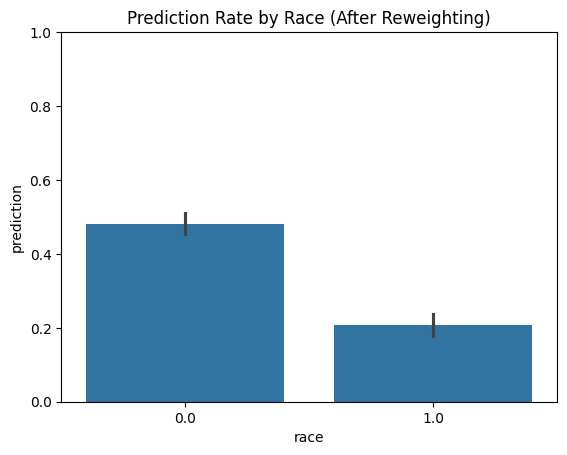

In [21]:
# 📊 Step 10: Visualize Prediction Rate by Race (After)
sns.barplot(data=df_after, x='race', y='prediction')
plt.title('Prediction Rate by Race (After Reweighting)')
plt.ylim(0, 1)
plt.show()

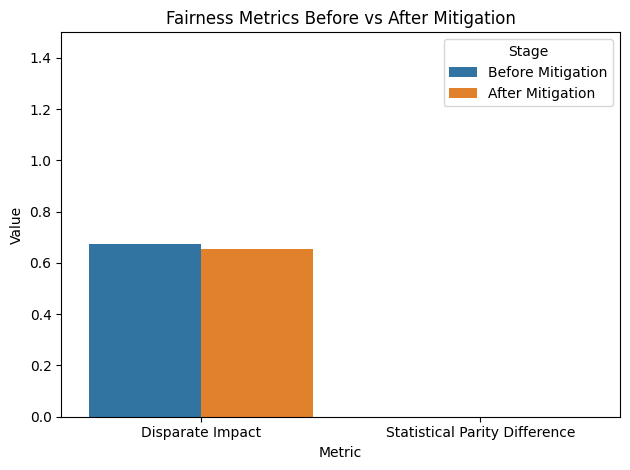

In [22]:
# 📈 Step 11: Compare Fairness Metrics Before vs After
metrics_df = pd.DataFrame({
    'Metric': ['Disparate Impact', 'Statistical Parity Difference'],
    'Before Mitigation': [di_before, spd_before],
    'After Mitigation': [di_after, spd_after]
})

metrics_melted = metrics_df.melt(id_vars='Metric', var_name='Stage', value_name='Value')

sns.barplot(data=metrics_melted, x='Metric', y='Value', hue='Stage')
plt.title('Fairness Metrics Before vs After Mitigation')
plt.ylim(0, 1.5)
plt.tight_layout()
plt.show()